In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Conditional VAE for genetic circuits

This notebook follows the previous VAE notebook very closely, but implementing a conditional VAE instead. Loosely following [this blog post](https://agustinus.kristia.de/techblog/2016/12/17/conditional-vae/) with the associated [github](https://github.com/wiseodd/generative-models/blob/master/VAE/conditional_vae/cvae_pytorch.py).

## Imports 

In [83]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation
from synbio_morpher.utils.data.data_format_tools.common import write_json
from functools import partial

from sklearn.metrics import r2_score  
import os
import sys
import numpy as np
import haiku as hk
import jax
import optax

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

import wandb

from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'cpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)

PRNG = jax.random.PRNGKey(0)

jax.devices()



[CpuDevice(id=0)]

In [84]:
from evoscaper.model.vae import CVAE, sample_z
from evoscaper.model.mlp import MLP
from evoscaper.model.shared import arrayise
from evoscaper.model.loss import loss_wrapper, compute_accuracy_regression, mse_loss, accuracy_regression
from evoscaper.utils.preprocess import drop_duplicates_keep_first_n
from evoscaper.utils.math import convert_to_scientific_exponent
from evoscaper.utils.optimiser import make_optimiser
from evoscaper.utils.train import make_saves

## Load data

In [85]:
fn = '../data/raw/summarise_simulation/2024_11_21_144918/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/summarise_simulation/2023_07_17_222747/tabulated_mutation_info.csv'
data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
len(data)

897109

In [86]:
data['adaptability'] = calculate_adaptation(
    s=data['sensitivity_wrt_species-6'].values, 
    p=data['precision_wrt_species-6'].values)

## Hyperparameters

In [87]:
# Stats
SEED = 1
PRNG = jax.random.PRNGKey(SEED)

# Architecture
HIDDEN_SIZE = 32 # 64
ENC_LS = 64
DEC_LS = 64
NUM_ENC_LAYERS = 3
NUM_DEC_LAYERS = 3
enc_layers = [ENC_LS] * NUM_ENC_LAYERS # [128, 128, 64, 64] # 
dec_layers = [DEC_LS] * NUM_DEC_LAYERS # [64, 64, 128, 128] # 

# Dataset 
OBJECTIVE_COL = 'adaptability'
include_diffs = False
input_concat_axis = 0
X_TYPE = 'energies'  # 'binding_rates_dissociation' #  
OUTPUT_SPECIES = ['RNA_1', 'RNA_2']

# Dataset training
BATCH_SIZE = 128
SCALE_X_MINMAX = False
TOTAL_DS = None
TOTAL_DS_MAX = 3e6
N_BATCHES = TOTAL_DS_MAX // BATCH_SIZE
USE_X_LOGSCALE = False
USE_CATEGORICAL = False

# Training
EPOCHS = 1000
LEARNING_RATE = 1e-2
LEARNING_RATE_SCHED = 'cosine_decay'  # 'constant
TRAIN_SPLIT = 0.8
USE_DROPOUT = False
USE_L2_REG = False
USE_WARMUP = True
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
PRINT_EVERY = EPOCHS // 100

# Loss
loss_fn = partial(
    loss_wrapper, loss_f=mse_loss, use_l2_reg=USE_L2_REG) 
compute_accuracy = compute_accuracy_regression

# Save 
TASK = '_test'
save_path = str(datetime.now()).split(' ')[0].replace(
    '-', '_') + '__' + str(datetime.now()).split(' ')[-1].split('.')[0].replace(':', '_') + '_saves' + TASK
save_path = os.path.join('weight_saves', '01_cvae', save_path)


# Initialise

## Init data

In [88]:
filt = data['sample_name'].isin(OUTPUT_SPECIES) & ~data['precision_wrt_species-6'].isna() & ~data['sensitivity_wrt_species-6'].isna() & (data['precision_wrt_species-6'] < np.inf)

# Balance the dataset
df = data[filt]
# df = drop_duplicates_keep_first_n(df, get_true_interaction_cols(
#     data, X_TYPE, remove_symmetrical=True), n=100)
df.loc[:, 'adaptability'] = df['adaptability'].apply(lambda x: np.round(x, 1))

if TOTAL_DS is None:
    TOTAL_DS = len(df)

X_COLS = list(get_true_interaction_cols(data, X_TYPE, remove_symmetrical=True))
if include_diffs:
    X_COLS = X_COLS + \
        [[f'{i}_diffs' for i in get_true_interaction_cols(
            data, X_TYPE, remove_symmetrical=True)]]



/tmp/ipykernel_315431/3118887764.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[654.5 654.5 654.5 ... 654.5 651.8 654.5]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  df.loc[:, 'adaptability'] = df['adaptability'].apply(lambda x: np.round(x, 1))


### Subsample overrepresented points

In [89]:
def pre_balance(df, cols, use_log, func_cols):
    d = np.log10(df[cols].to_numpy()) if use_log else df[cols].to_numpy()
    if func_cols is not None:
        d = func_cols(d)
    if use_log:  # Remove -inf
        d = np.where(d < -100.0, -100.0, d)
        d = np.where(d > 100.0, 100.0, d)
    return d


def find_idxs_remove(bin_edges, i, d, h, bin_max, to_remove):
    edge_lo, edge_hi = bin_edges[i], bin_edges[i+1]
    inds = np.where((d >= edge_lo) & (d <= edge_hi))[0]
    to_remove = np.concatenate([to_remove, np.random.choice(inds, int(h - bin_max), replace=False)]).astype(int)
    return to_remove


def rem_idxs(df, to_remove):
    mask = np.ones(len(df), dtype=bool)
    mask[to_remove] = False
    df = df.iloc[mask]
    return df


def balance_dataset(df, cols, nbin, bin_max, use_log, func_cols=None):
    d = pre_balance(df, cols, use_log, func_cols)
        
    hist, bin_edges = np.histogram(d, bins=nbin)
    
    to_remove = np.array([])
    over_count = 0
    for i, h in enumerate(hist):
        if h > bin_max:
            over_count += 1
            to_remove = find_idxs_remove(bin_edges, i, d, h, bin_max, to_remove)
            assert len(to_remove) == np.sum(np.where((hist[:i+1] - bin_max) > 0, hist[:i+1], 0)) - over_count*bin_max, 'something wrong'

    df = rem_idxs(df, to_remove)
    return df


def balance_dataset2d(df, cols1, cols2, nbins, bin_max, use_log, func1, func2):
    d1 = pre_balance(df, cols1, use_log, func1)
    d2 = pre_balance(df, cols2, use_log, func2)
    hist, bin_edges_x, bin_edges_y = np.histogram2d(d1, d2, bins=nbins)

    to_remove = np.array([])
    for ix, iy in zip(*np.where(hist > bin_max)):
        
        to_remove = find_idxs_remove(bin_edges_x, ix, d1, hist[ix, iy], bin_max, to_remove)
        to_remove = find_idxs_remove(bin_edges_y, iy, d2, hist[ix, iy], bin_max, to_remove)
        # edge_lo, edge_hi = bin_edges_x[ix], bin_edges_x[ix+1]
        # inds = func1(df[cols1]).between(edge_lo, edge_hi).index
        # to_remove = np.concatenate([to_remove, np.random.choice(inds, int(hist[ix, iy] - bin_max), replace=False)]).astype(int)
        
    to_remove = list(set(to_remove))
    df = rem_idxs(df, to_remove)
    return df

# df = balance_dataset(df, X_COLS, 50, 100, use_log=USE_X_LOGSCALE)

First reduce the number of null circuits

In [90]:
df = df.reset_index(drop=True)

Text(0.5, 0.98, 'Balancing null circuits')

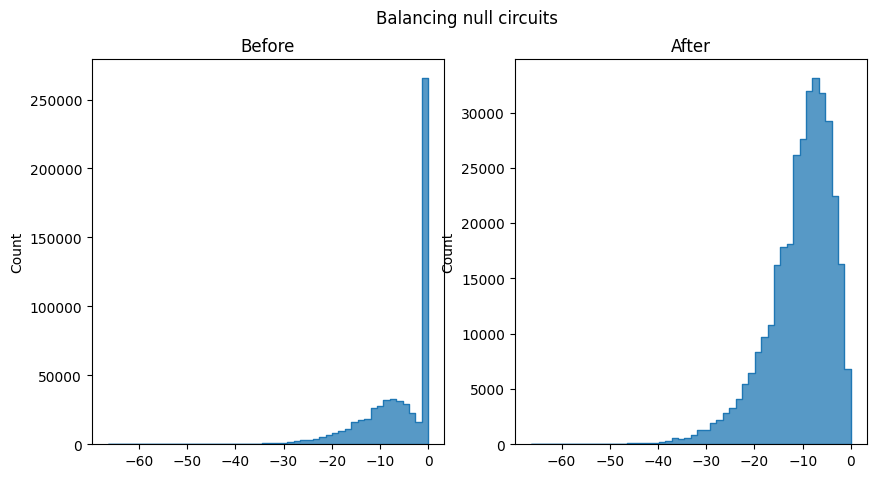

In [91]:
n_null_max = 100
idxs_null = df[df[X_COLS].sum(axis=1) == 0].index

df_bal = rem_idxs(df, np.random.choice(idxs_null, len(idxs_null) - n_null_max, replace=False))


fig = plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.histplot(df[X_COLS].sum(axis=1), bins=50, element='step')
plt.title('Before')
ax = plt.subplot(1,2,2)
plt.title('After')
sns.histplot(df_bal[X_COLS].sum(axis=1), bins=50, element='step')
plt.suptitle('Balancing null circuits')


<Axes: xlabel='adaptability'>

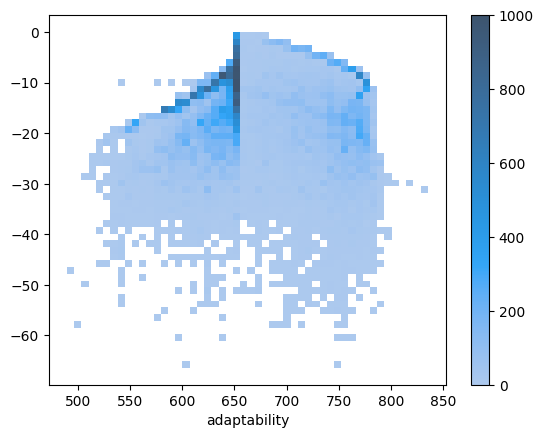

In [ ]:
# bin_max = int(np.power(10, 3))
# nbin = 50
# func1 = lambda x: np.sum(x, axis=1)
# df_bal = balance_dataset2d(df.reset_index(drop=True), cols1=X_COLS, cols2=OBJECTIVE_COL, nbins=nbin, bin_max=bin_max, use_log=False, func1=func1, func2=None)

# # For some reason need to recurse this subsampling
# for i in range(20):
#     df_bal = balance_dataset2d(df_bal, cols1=X_COLS, cols2=OBJECTIVE_COL, nbins=nbin, bin_max=bin_max, use_log=False, func1=func1, func2=None)

sns.histplot(x=df_bal[OBJECTIVE_COL].T, y=func1(df_bal[X_COLS].values).T, bins=nbin, cbar=True)


Text(0.5, 0.98, 'Balance of dataset for conditioning variable adaptability')

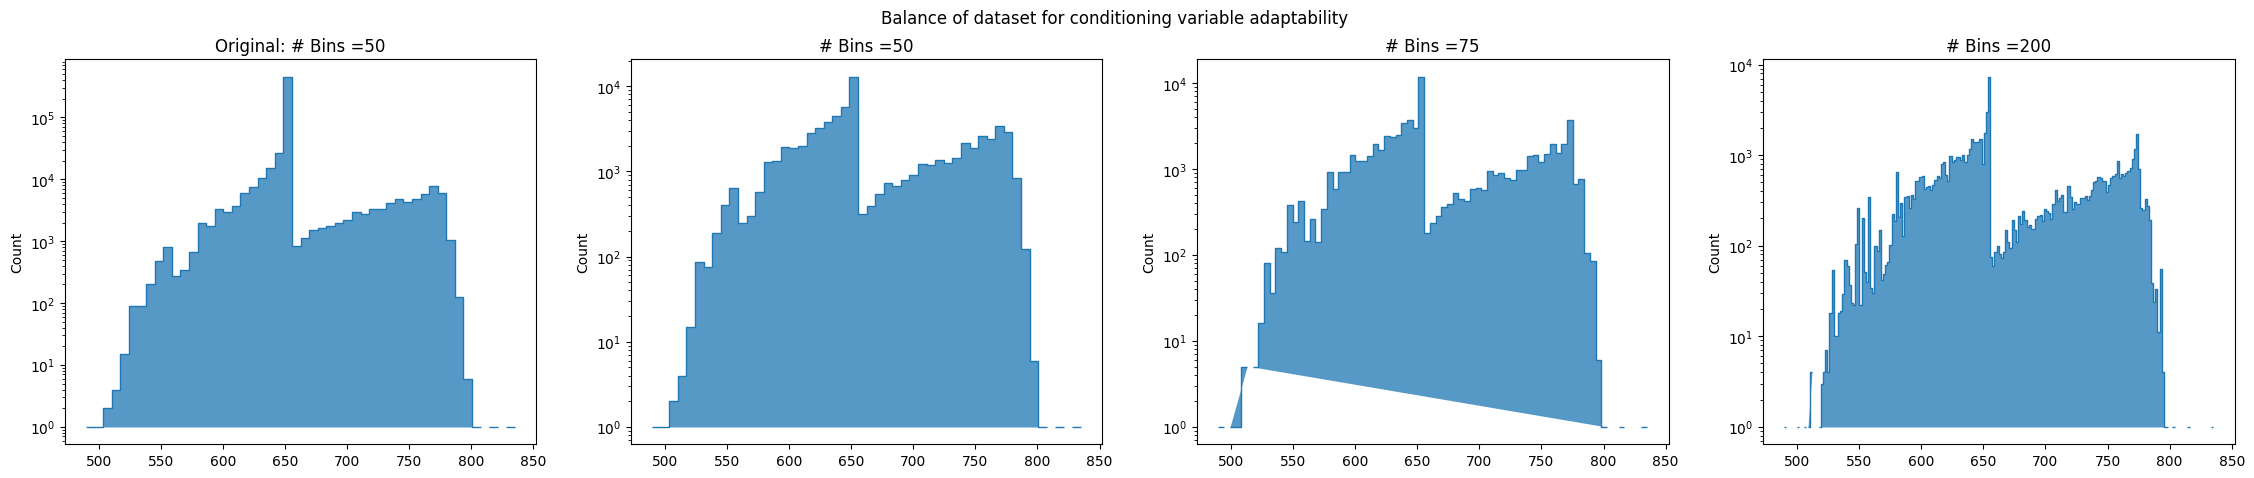

In [53]:
TOTAL_DS = np.min([TOTAL_DS, TOTAL_DS_MAX, len(df)])

# Balance by bins
nbin = 50
bin_max = int(np.power(10, 3))
# df_bal = balance_dataset(df, cols=OBJECTIVE_COL, nbin=nbin, bin_max=bin_max, use_log=False)
# df_bal = balance_dataset(df, cols=X_COLS, nbin=300, bin_max=bin_max, use_log=False, func_cols=lambda x: np.sum(x, axis=1))

fig = plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1,4,1)
sns.histplot(df[OBJECTIVE_COL].to_numpy().flatten(), bins=50, log_scale=[False, True], element='step')
plt.title('Original: # Bins =' + str(50))
ax = plt.subplot(1,4,2)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=nbin, log_scale=[False, True], element='step')
plt.title('# Bins =' + str(nbin))
ax = plt.subplot(1,4,3)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=int(nbin*1.5), log_scale=[False, True], element='step')
plt.title('# Bins =' + str(int(nbin*1.5)))
ax = plt.subplot(1,4,4)
sns.histplot(df_bal[OBJECTIVE_COL].to_numpy().flatten(), bins=nbin*4, log_scale=[False, True], element='step')
plt.title('# Bins =' + str(nbin*4))

plt.suptitle('Balance of dataset for conditioning variable ' + str(OBJECTIVE_COL))


Text(0, 0.5, 'Energies mean')

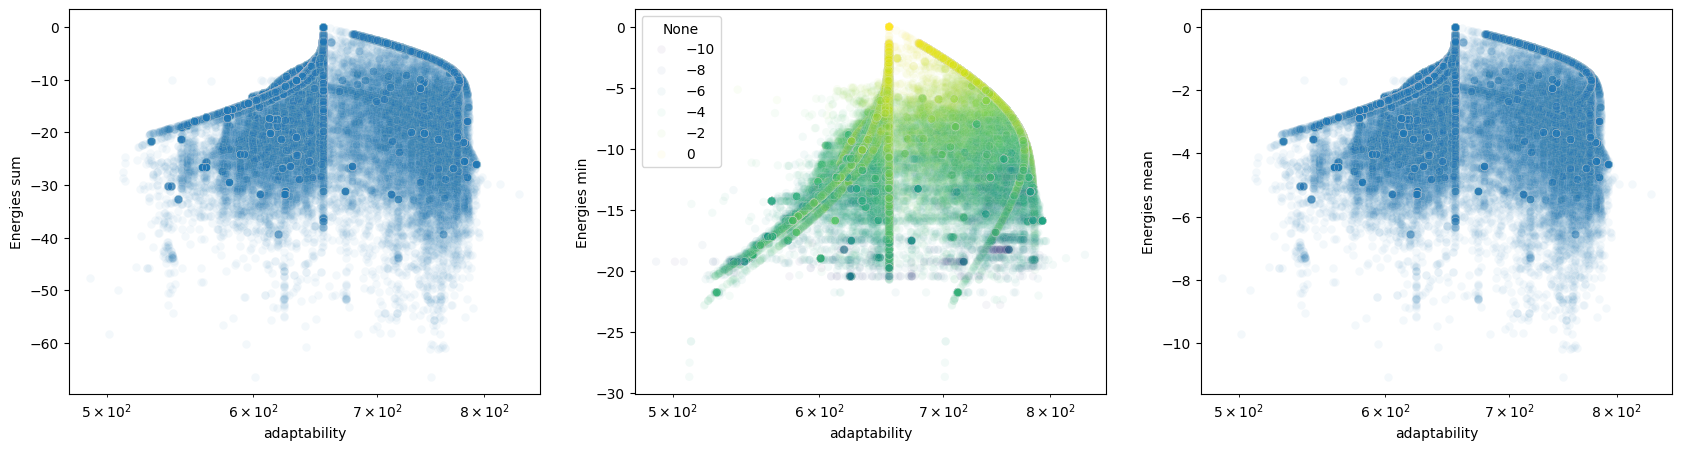

In [32]:
plt.figure(figsize=(4*7, 5))
ax = plt.subplot(1,4,1)
sns.scatterplot(x=df_bal[OBJECTIVE_COL], y=df_bal[X_COLS].sum(axis=1), alpha=0.05)
plt.xscale('log')
plt.ylabel('Energies sum')
ax = plt.subplot(1,4,2)
sns.scatterplot(x=df_bal[OBJECTIVE_COL], y=df_bal[X_COLS].min(axis=1), alpha=0.05,
                hue=df_bal[X_COLS].mean(axis=1), palette='viridis')
plt.xscale('log')
plt.ylabel('Energies min')
ax = plt.subplot(1,4,3)
sns.scatterplot(x=df_bal[OBJECTIVE_COL], y=df_bal[X_COLS].mean(axis=1), alpha=0.05)
plt.xscale('log')
plt.ylabel('Energies mean')

In [ ]:
x = [df[i].iloc[:TOTAL_DS].values[:, :, None] for i in X_COLS]
x = np.concatenate(x, axis=input_concat_axis+1).squeeze()

Scale the input data

In [51]:
x_scaling, x_unscaling = [], []
if USE_X_LOGSCALE:
    x_scaling.append(np.log10)
    x_unscaling.append(lambda x: np.power(10, x))

if SCALE_X_MINMAX:
    xscaler = MinMaxScaler()
    x_scaling.append(xscaler.fit_transform)
    x_unscaling.append(xscaler.inverse_transform)

x_unscaling = x_unscaling[::-1]

for fn in x_scaling:
    x = fn(x)

### Conditional

In [ ]:
cond = df[OBJECTIVE_COL].iloc[:TOTAL_DS].to_numpy()

if USE_CATEGORICAL:

    vectorized_convert_to_scientific_exponent = np.vectorize(
        convert_to_scientific_exponent)
    numerical_resolution = 2
    cond_map = {k: numerical_resolution for k in np.arange(int(f'{cond[cond != 0].min():.0e}'.split(
        'e')[1])-1, np.max([int(f'{cond.max():.0e}'.split('e')[1])+1, 0 + 1]))}
    cond_map[-6] = 1
    cond_map[-5] = 1
    cond_map[-4] = 4
    cond_map[-3] = 2
    cond_map[-1] = 3
    cond = jax.tree_util.tree_map(partial(
        vectorized_convert_to_scientific_exponent, numerical_resolution=cond_map), cond)
    cond = np.interp(cond, sorted(np.unique(cond)), np.arange(
        len(sorted(np.unique(cond))))).astype(int)
else:
    zero_log_replacement = -10.0
    cond = np.where(cond != 0, np.log10(cond), zero_log_replacement)

cond = cond[:, None]
N_HEAD = x.shape[-1]

x, cond = shuffle(x, cond, random_state=SEED)

if x.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {x.shape[0]} vs. requested {TOTAL_DS}')

In [11]:
np.concatenate([x, cond], axis=1).shape

(153600, 7)

Text(0.5, 0.98, 'Dataset after balancing')

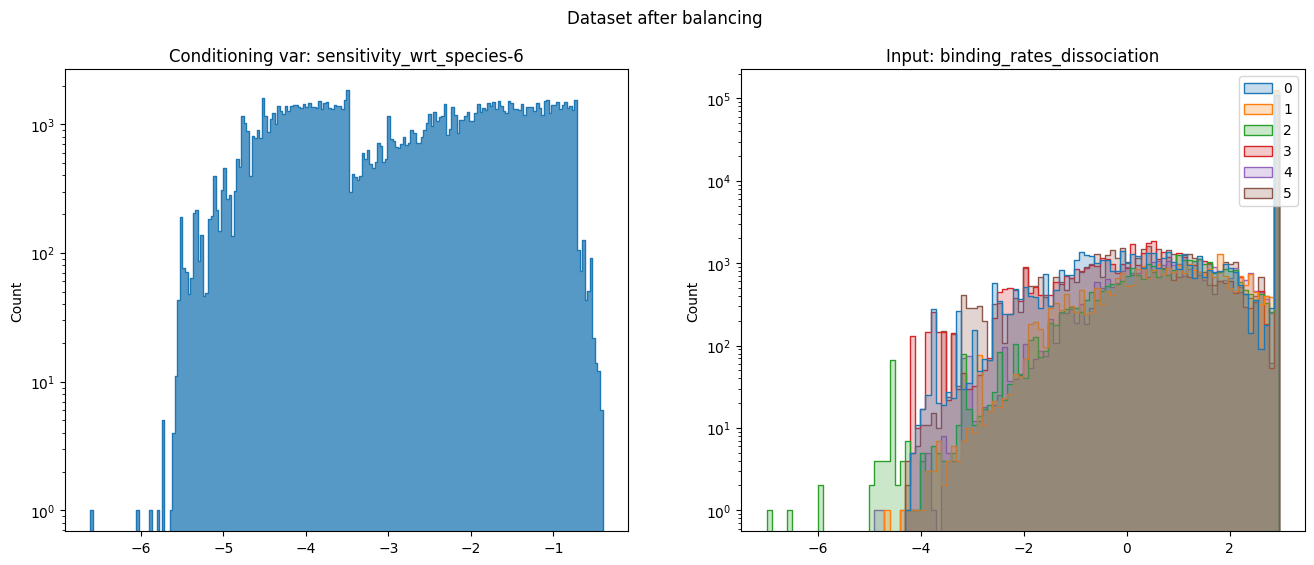

In [ ]:
fig = plt.figure(figsize=(2*8, 6))

ax = plt.subplot(1,2,1)
sns.histplot(cond.flatten(), log_scale=[False, True], bins=200, element='step')
plt.title(f'Conditioning var: {OBJECTIVE_COL}')

ax = plt.subplot(1,2,2)
sns.histplot(x, element='step', bins=100, log_scale=[False, True])
plt.title(f'Input: {X_TYPE}')

plt.suptitle('Dataset after balancing')

## Init model

In [ ]:
def VAE_fn(enc_layers: list, dec_layers: list, call_kwargs: dict = {}):
    encoder = MLP(layer_sizes=enc_layers, n_head=dec_layers[0], use_categorical=False, name='encoder')
    decoder = MLP(layer_sizes=dec_layers, n_head=x.shape[-1], use_categorical=False, name='decoder')
    model = CVAE(encoder=encoder, decoder=decoder, embed_size=HIDDEN_SIZE)
    
    def init(x: np.ndarray, cond: np.ndarray, deterministic: bool):
        h = model.encoder(np.concatenate([x, cond], axis=-1))

        mu = model.h2mu(h)
        logvar = model.h2logvar(h)
        z = model.reparameterize(mu, logvar, hk.next_rng_key(), deterministic)
        z_cond = np.concatenate([z, cond], axis=-1)

        y = model.decoder(z_cond)
        return y
        
    return init, (encoder, decoder, model) #model(x, **call_kwargs)

model_fn = partial(VAE_fn, enc_layers=enc_layers, dec_layers=dec_layers)
# model = hk.transform(model_fn)
model_t = hk.multi_transform(model_fn)
params = model_t.init(PRNG, x, cond, deterministic=False)


/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/initializers.py:126: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/home/wadh6511/Kode/env_evo/lib/python3.10/site-packages/haiku/_src/base.py:682: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [14]:
encoder, decoder, model = model_t.apply

In [ ]:
h = encoder(params, PRNG, np.concatenate([x, cond], axis=-1))

In [ ]:
model(params, PRNG, x, cond)

Array([[ 0.74667203,  0.55660796, -0.09307013,  0.15708387,  0.81156135,
         0.9505105 ],
       [ 1.1686935 ,  0.49520233, -0.06329086,  0.3382175 ,  0.81847584,
         0.92352325],
       [ 1.2343109 ,  0.5630622 ,  0.05603989,  0.24910663,  0.4007836 ,
         1.3721708 ],
       ...,
       [ 0.73158866,  0.17424317,  0.14041403,  0.3577196 ,  0.6518938 ,
         0.8709855 ],
       [ 0.9970119 ,  0.2366354 ,  0.01763288,  0.33578524,  0.8398403 ,
         1.2257041 ],
       [ 1.028729  ,  0.5292946 ,  0.1129427 ,  0.21458201,  1.070392  ,
         0.906651  ]], dtype=float32)

## Init optimiser

In [17]:
optimiser = make_optimiser(LEARNING_RATE_SCHED, LEARNING_RATE,
                           EPOCHS, L2_REG_ALPHA, USE_WARMUP, WARMUP_EPOCHS, N_BATCHES)
optimiser_state = optimiser.init(x)

# Train

In [18]:
# [i_batch, Batches, *content]

x = x.reshape(N_BATCHES, BATCH_SIZE, x.shape[-1])
cond = cond.reshape(N_BATCHES, BATCH_SIZE, cond.shape[-1])
y = x.reshape(N_BATCHES, BATCH_SIZE, x.shape[-1])

x_train, cond_train, y_train = x[:int(TRAIN_SPLIT * N_BATCHES)], cond[:int(TRAIN_SPLIT * N_BATCHES)], y[:int(TRAIN_SPLIT * N_BATCHES)]
x_val, cond_val, y_val = x[int(TRAIN_SPLIT * N_BATCHES):], cond[int(TRAIN_SPLIT * N_BATCHES):], y[int(TRAIN_SPLIT * N_BATCHES):]

x_train.shape

In [34]:
np.prod(x_train.shape[:2])


122880

In [19]:
def train_step(params, x, y, cond, optimiser_state, model, rng, use_l2_reg, l2_reg_alpha, optimiser, loss_fn):

    loss, grads = jax.value_and_grad(loss_fn)(
        params, rng, model, x, y, use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, cond=cond)

    updates, optimiser_state = optimiser.update(grads, optimiser_state)
    params = optax.apply_updates(params, updates)

    return params, optimiser_state, loss, grads


def eval_step(params, rng, model, x, y, cond, use_l2_reg, l2_reg_alpha, loss_fn, compute_accuracy):
    """ Return the average of loss and accuracy on validation data """
    loss = loss_fn(params, rng, model, x, y, use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, cond=cond)
    pred_y = model(params, rng, x, cond=cond)
    acc = compute_accuracy(pred_y, y)
    return acc, loss


def run_batches(params, model, rng,
                x_batch, y_batch, cond_batch,
                use_l2_reg, l2_reg_alpha, optimiser, optimiser_state, loss_fn):

    f_train_step = partial(train_step, model=model, rng=rng,
                           use_l2_reg=use_l2_reg, l2_reg_alpha=l2_reg_alpha, optimiser=optimiser,
                           loss_fn=loss_fn)

    def f(carry, inp):

        params, optimiser_state = carry[0], carry[1]
        x_batch, y_batch, cond_batch = inp[0], inp[1], inp[2]

        params, optimiser_state, loss, grads = f_train_step(
            params, x_batch, y_batch, cond_batch, optimiser_state)
        return (params, optimiser_state), (loss, grads)

    # for x_batch, y_batch in xy_train:
    (params, optimiser_state), (train_loss, grads) = jax.lax.scan(
        f, (params, optimiser_state), (x_batch, y_batch, cond_batch))
    return params, optimiser_state, train_loss, grads


def train(params, rng, model,
          x_train, cond_train, y_train, x_val, cond_val, y_val,
          optimiser, optimiser_state,
          use_l2_reg, l2_reg_alpha, epochs,
          loss_fn, compute_accuracy,
          save_every, include_params_in_saves):

    def f(carry, _):
        params, optimiser_state = carry[0], carry[1]

        params, optimiser_state, train_loss, grads = run_batches(
            params, model, rng, x_train, y_train, cond_train, use_l2_reg, l2_reg_alpha, optimiser, optimiser_state, loss_fn)

        val_acc, val_loss = eval_step(
            params, rng, model, x_val, y_val, cond_val, use_l2_reg, l2_reg_alpha, loss_fn, compute_accuracy)

        return (params, optimiser_state), (params, grads, train_loss, val_loss, val_acc)

    saves = {}
    for e in range(epochs):
        (params, optimiser_state), (params_stack, grads, train_loss,
                                    val_loss, val_acc) = f((params, optimiser_state), None)

        if np.mod(e, save_every) == 0:
            saves[e] = make_saves(
                train_loss, val_loss, val_acc, include_params_in_saves, params_stack, grads)
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {np.mean(train_loss)}\tVal loss: {val_loss}\tVal accuracy: {val_acc}')

    saves[list(saves.keys())[-1]]['params'] = params
    return params, saves

In [ ]:
tstart = datetime.now()
params, saves = train(params, PRNG, model, 
                      x_train, cond_train, y_train, x_val, cond_val, y_val, 
                      optimiser, optimiser_state,
                      use_l2_reg=USE_L2_REG, l2_reg_alpha=L2_REG_ALPHA, epochs=EPOCHS,
                      loss_fn=loss_fn, compute_accuracy=accuracy_regression,
                      save_every=PRINT_EVERY, include_params_in_saves=False) 

print(datetime.now() - tstart)

Epoch 0 / 1000 -		 Train loss: 4.693556785583496	Val loss: 4.235050201416016	Val accuracy: 0.0108778215944767
Epoch 10 / 1000 -		 Train loss: 1.629782795906067	Val loss: 1.6243016719818115	Val accuracy: 0.13467340171337128
Epoch 20 / 1000 -		 Train loss: 1.521235704421997	Val loss: 1.5073530673980713	Val accuracy: 0.1420084685087204
Epoch 30 / 1000 -		 Train loss: 0.918708324432373	Val loss: 0.8924319744110107	Val accuracy: 0.33311089873313904
Epoch 40 / 1000 -		 Train loss: 0.5249311923980713	Val loss: 0.5171193480491638	Val accuracy: 0.46234267950057983


KeyboardInterrupt: 

# Visualise

Text(0.5, 0, 'step')

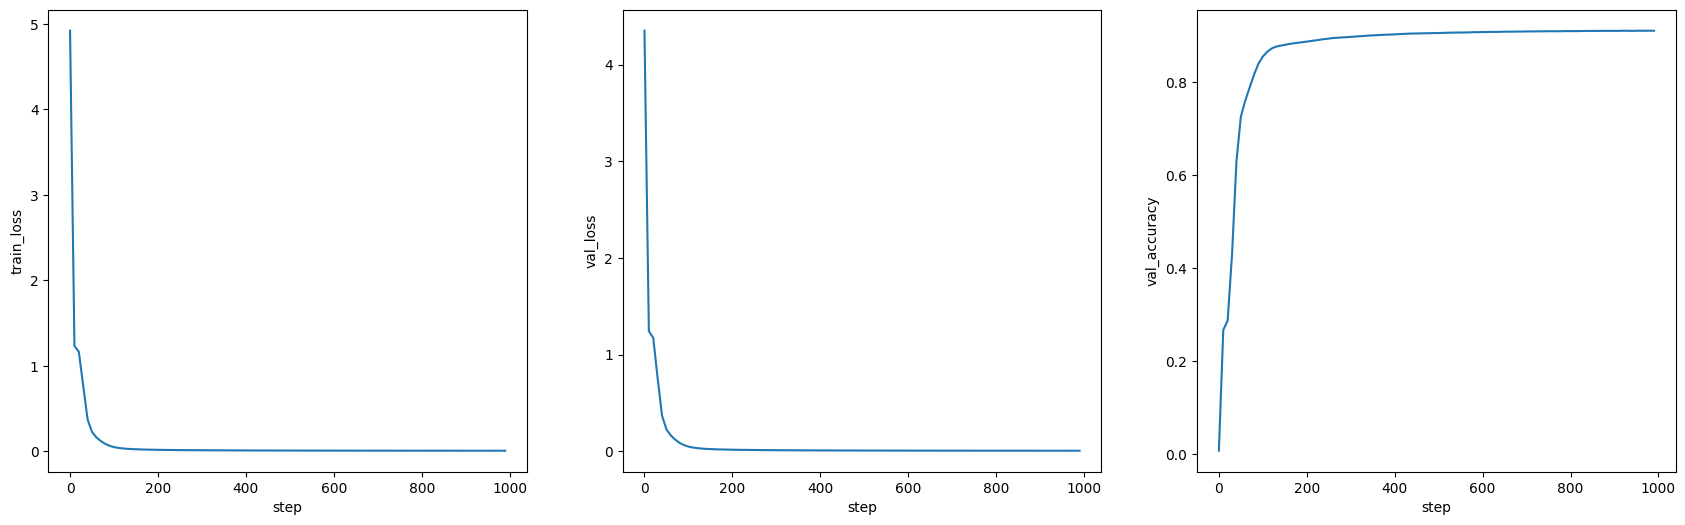

In [ ]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(saves.keys()), [v['train_loss'] for v in saves.values()])
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(saves.keys()), [v['val_loss'] for v in saves.values()])
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(saves.keys()), [v['val_accuracy'] for v in saves.values()])
plt.ylabel('val_accuracy')
plt.xlabel('step')

In [ ]:
write_json(saves, out_path=save_path)

In [ ]:
print(save_path)

weight_saves/10_cvae/2024_02_04__15_54_15_saves_test


# Examine trained model

In [ ]:
fn_saves = os.path.join('weight_saves', '10_cvae', '2023_12_14__11_37_03_saves_test')
fn_saves = os.path.join('weight_saves', '10_cvae', '2023_12_20__23_24_49_saves_hiddens64')
fn_saves = os.path.join('weight_saves', '10_cvae', '2023_12_21__12_51_46_saves_hs64_ls4')
fn_saves = os.path.join('weight_saves', '10_cvae', '2023_12_21__14_46_08_saves_hs64_ls4_e2000')
fn_saves = os.path.join('weight_saves', '10_cvae', '2023_12_21__14_18_00_saves_alldata')
fn_saves = os.path.join('weight_saves', '10_cvae', '2024_02_04__15_54_15_saves_test')
fn_saves = os.path.join('weight_saves', '10_cvae', '2024_02_23__10_21_00_saves_test')
# fn_saves = save_path
saves_loaded = load_json_as_dict(fn_saves)

p = saves_loaded[str(list(saves_loaded.keys())[-1])]['params']
p = arrayise(p)
# p['vae/~/h2mu'] = p.pop('vae/~/linear')
# p['vae/~/h2logvar'] = p.pop('vae/~/linear_1')

pred_y = model(p, PRNG, x, cond)
pred_y.shape

(1200, 128, 6)

Text(0.5, 0, 'step')

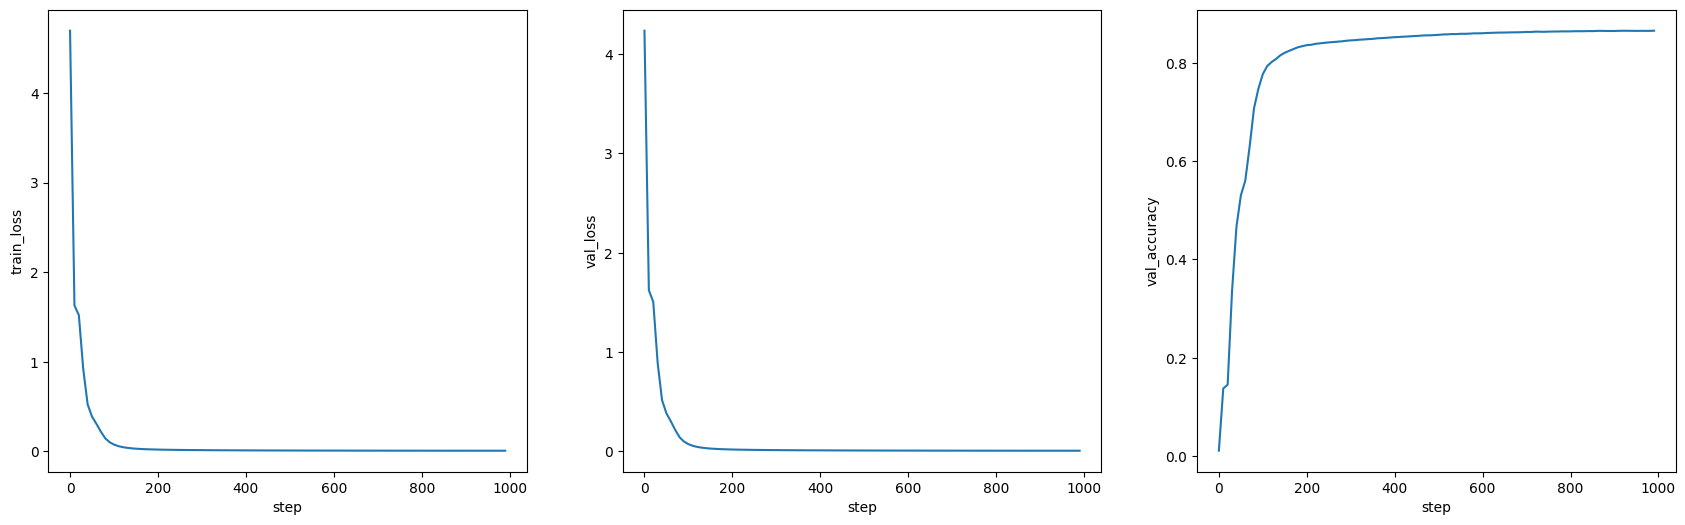

In [21]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1, 3, 1)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['train_loss']) for v in saves_loaded.values()]))
plt.ylabel('train_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 2)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_loss']) for v in saves_loaded.values()]))
plt.ylabel('val_loss')
plt.xlabel('step')
ax = plt.subplot(1, 3, 3)
plt.plot(list(map(float, saves_loaded.keys())), np.array([float(v['val_accuracy']) for v in saves_loaded.values()]))
plt.ylabel('val_accuracy')
plt.xlabel('step')

The R2 score is  0.9951938449304771
The R2 score with weighted variance is  0.9951938449304771


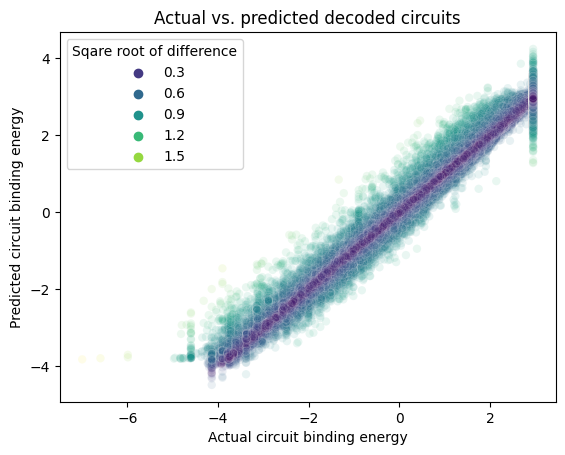

In [22]:
g = sns.scatterplot(x=y.flatten(), y=pred_y.flatten(), alpha=0.1, hue=np.sqrt(np.abs(pred_y.flatten() - y.flatten())), palette='viridis')
g.legend_.set_title('Sqare root of difference')
plt.title(f'Actual vs. predicted decoded circuits')
plt.xlabel('Actual circuit binding energy')
plt.ylabel('Predicted circuit binding energy')

print('The R2 score is ', r2_score(y.flatten(), pred_y.flatten()))
print('The R2 score with weighted variance is ', r2_score(
    y.flatten(), pred_y.flatten(), multioutput='variance_weighted'))

# Sample fake circuits

In [ ]:
n_to_sample = 10000

sampled_cond = np.interp(np.random.rand(n_to_sample, cond.shape[-1]), [0, 1], [cond.min(), cond.max()])
mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 5000
logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 100
z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = decoder(p, PRNG, z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)
sampled_cond.shape

(10000, 1)

Text(0.5, 0.98, 'CVAE: 10000 circuits')

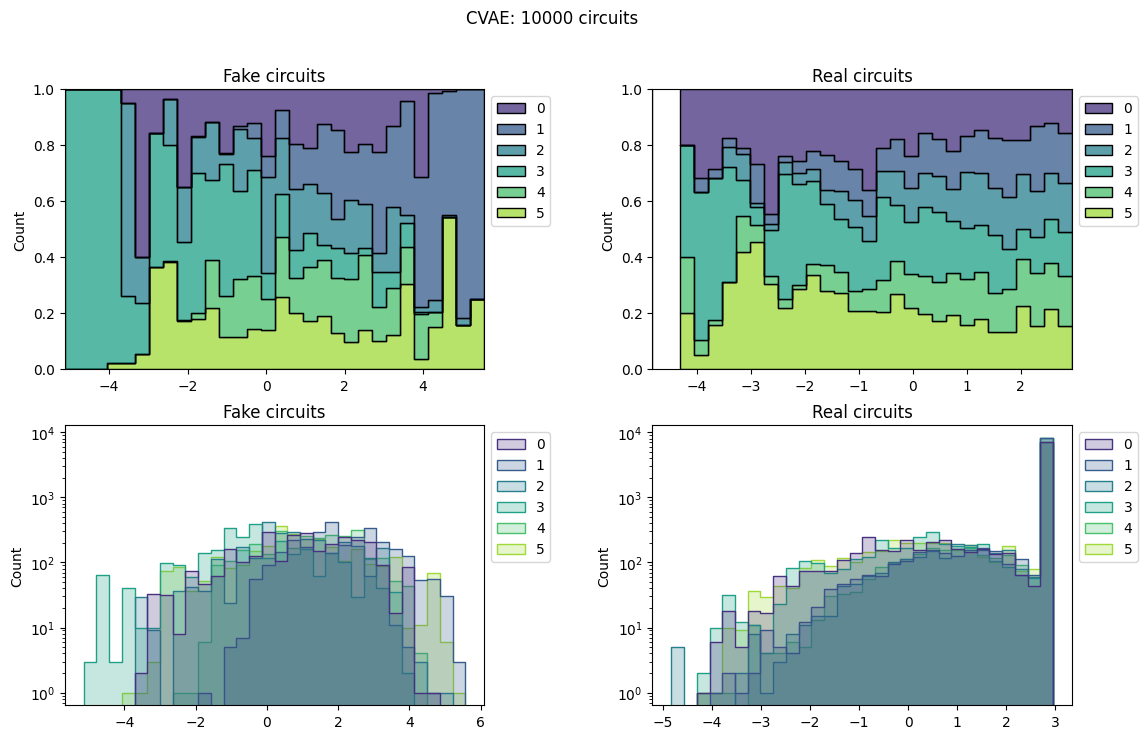

In [24]:
fig = plt.figure(figsize=(13, 8))
fig.subplots_adjust(wspace=0.4)

ax = plt.subplot(2,2,1)
g = sns.histplot(fake_circuits, element='step', bins=30, palette='viridis', multiple='fill')
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2,2,2)
g = sns.histplot(x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample], 
             element='step', bins=30, palette='viridis', multiple='fill')
plt.title('Real circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2,2,3)
g = sns.histplot(fake_circuits, element='step', bins=30, palette='viridis', multiple='layer', fill=True, log_scale=[False, True])
plt.title('Fake circuits')
sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))

ax = plt.subplot(2,2,4)
g2 = sns.histplot(x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:n_to_sample], 
             element='step', bins=30, palette='viridis', multiple='layer', fill=True, log_scale=[False, True])
plt.title('Real circuits')
sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))

g.set_ylim(g2.get_ylim())

plt.suptitle(f'CVAE: {n_to_sample} circuits')

Text(0.5, 0.98, 'CVAE: 1000 circuits')

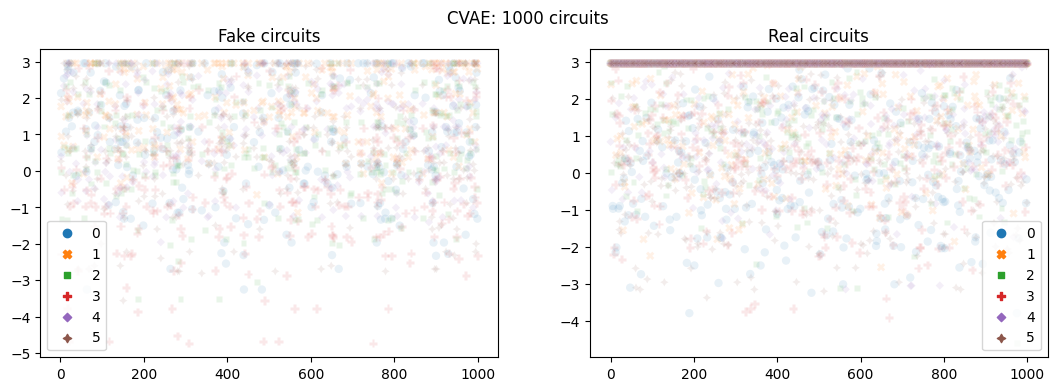

In [25]:
fig = plt.figure(figsize=(13, 4))

show_max = 1000

ax = plt.subplot(1,2,1)
sns.scatterplot(np.where(fake_circuits[:show_max] > x.max(), x.max(), fake_circuits[:show_max]), alpha=0.1)
plt.title('Fake circuits')

ax = plt.subplot(1,2,2)
sns.scatterplot(x.reshape(np.prod(x.shape[:-1]), x.shape[-1])[:show_max], alpha=0.1)
plt.title('Real circuits')

plt.suptitle(f'CVAE: {show_max} circuits')

## Conditionality

In [ ]:
n_categories = 5
n_to_sample = 10000

sampled_cond = np.repeat(np.linspace(cond.min(), cond.max(), n_categories)[:, None], repeats=n_to_sample, axis=1)[:, :, None]
mu = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 1
logvar = np.random.normal(size=(n_to_sample, HIDDEN_SIZE)) * 2
z = sample_z(mu=mu, logvar=logvar, key=PRNG)
z = np.repeat(z[None, :], repeats=n_categories, axis=0)
z = np.concatenate([z, sampled_cond], axis=-1)

fake_circuits = jax.vmap(partial(decoder, params=p, rng=PRNG))(x=z)
# fake_circuits = np.where(fake_circuits > 0, 0, fake_circuits)

Text(0.5, 0.98, 'CVAE: fake circuits')

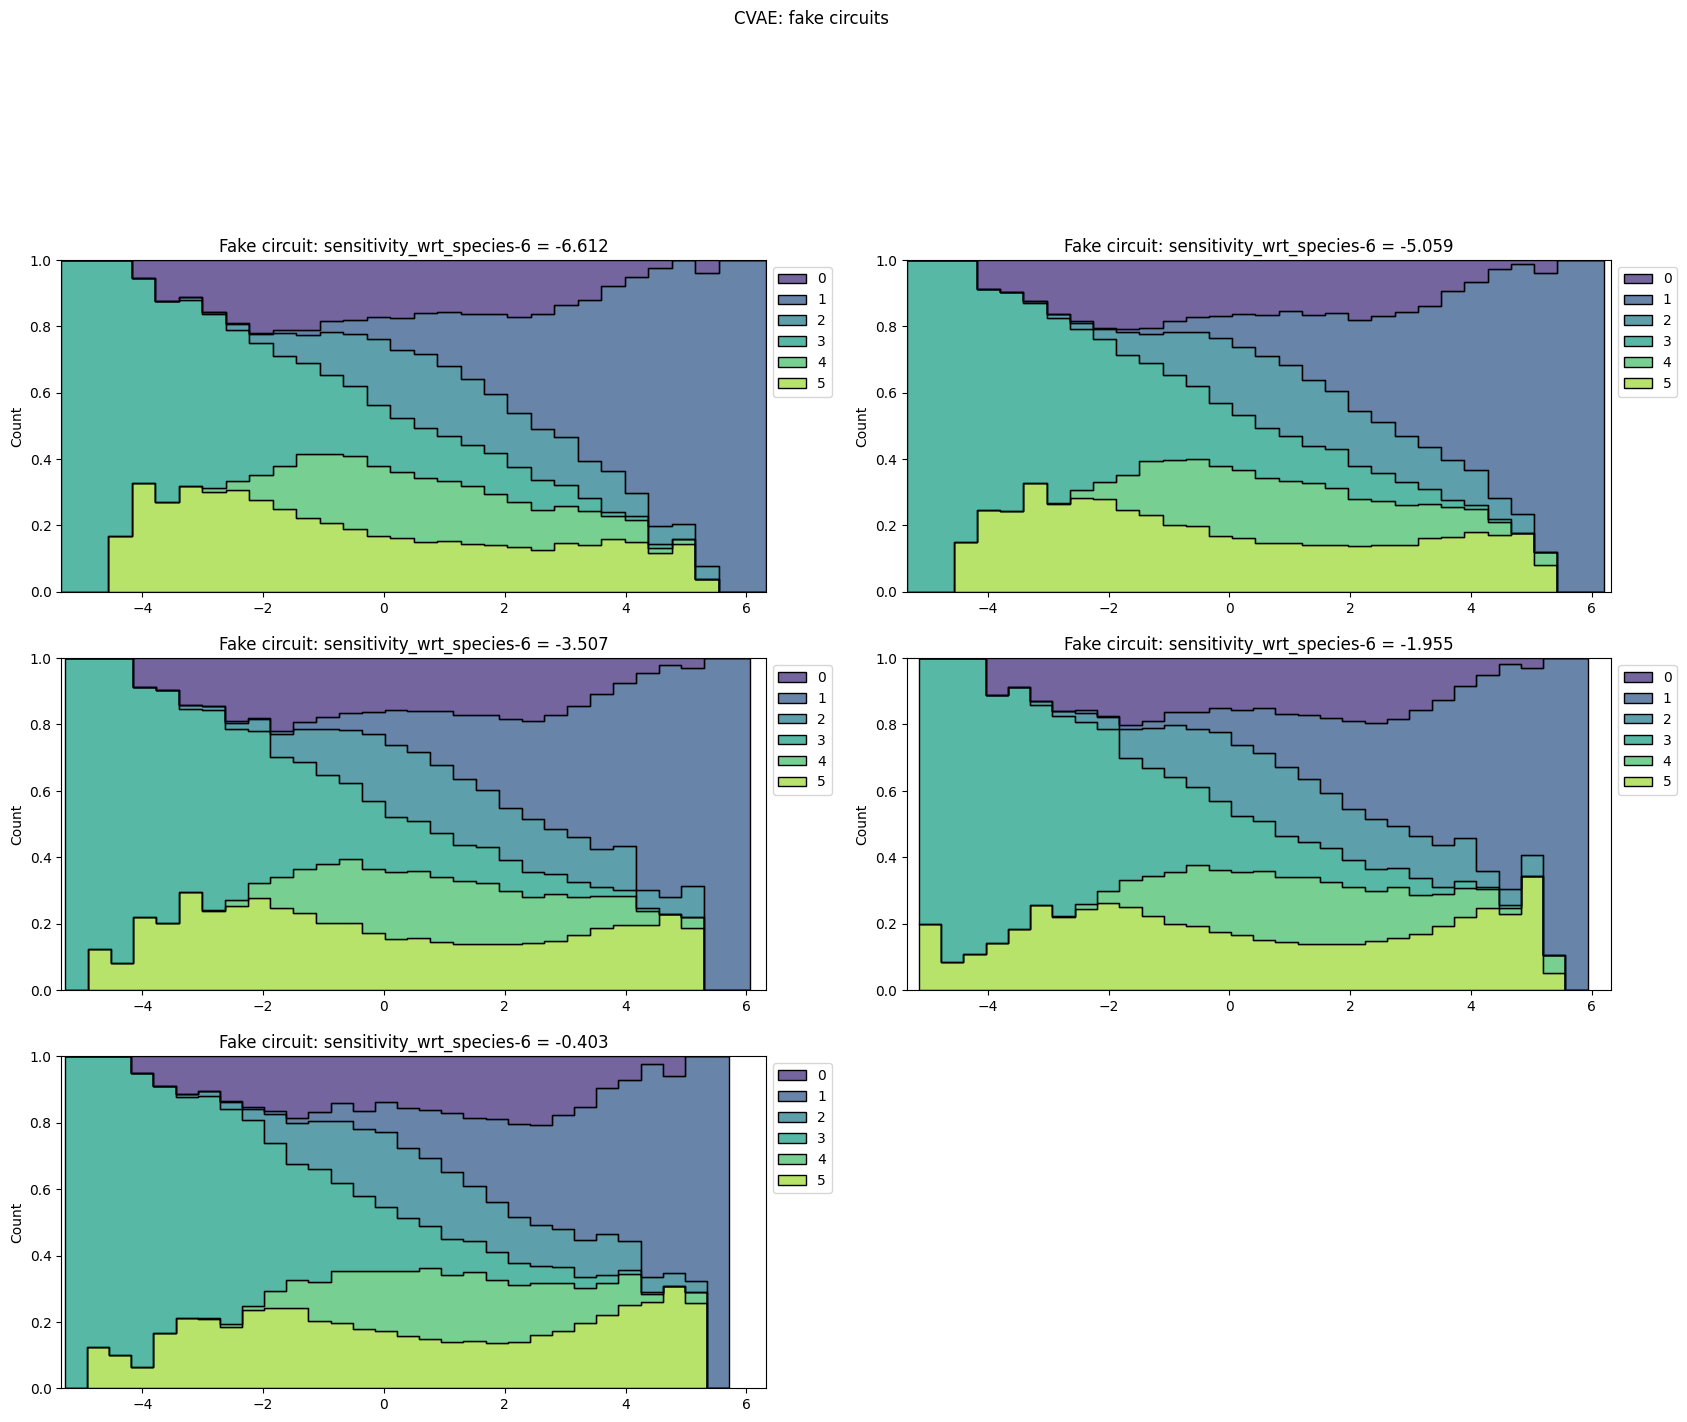

In [ ]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
widest_lim = [0, 0]
for i, (zi, cat) in enumerate(zip(z, fake_circuits)):
    ax = plt.subplot(5, 2, i+1)
    # g = sns.scatterplot(cat[:show_max])
    g = sns.histplot(cat, element='step', bins=30, palette='viridis', multiple='fill')
    plt.title(f'Fake circuit: {OBJECTIVE_COL} = {str(sorted(np.unique(sampled_cond))[i])[:6]}')
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
    widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
    g.set_xlim(widest_lim)

plt.suptitle(f'CVAE: fake circuits')

### Compare to real circuit's sensitivity

In [ ]:
def round_to_nearest_array(x, y):
    """ 
    x: array to be mapped over
    y: array with integers to round to """
    distances = np.abs(x[:, None] - y[None, :])
    nearest_indices = np.argmin(distances, axis=1)
    nearest_values = y[nearest_indices]
    return nearest_values


def bin_to_nearest_edge(x: np.ndarray, n_bins):
    """ Bin the elements in x to the nearest lowest bin """
    edges = np.linspace(x.min(), x.max(), n_bins)
    return round_to_nearest_array(x, edges)


def apply_fns(x, fns: list):
    og_shape = x.shape
    if x.ndim > 2:
        x = x.reshape(*(np.prod(x.shape[:-1]), x.shape[-1]))
    for fcn in fns:
        x = fcn(x)
    return x.reshape(og_shape)

df[OBJECTIVE_COL + '_nearest_edge'] = bin_to_nearest_edge(np.log10(df[OBJECTIVE_COL].to_numpy()), n_bins=n_categories)
fake_circuits = apply_fns(fake_circuits, fns = x_unscaling)


In [ ]:
fake_circuits = np.where(fake_circuits > df[X_COLS[0]].max().max(), df[X_COLS[0]].max().max(), fake_circuits)

Text(0.5, 0.98, 'CVAE: real circuits')

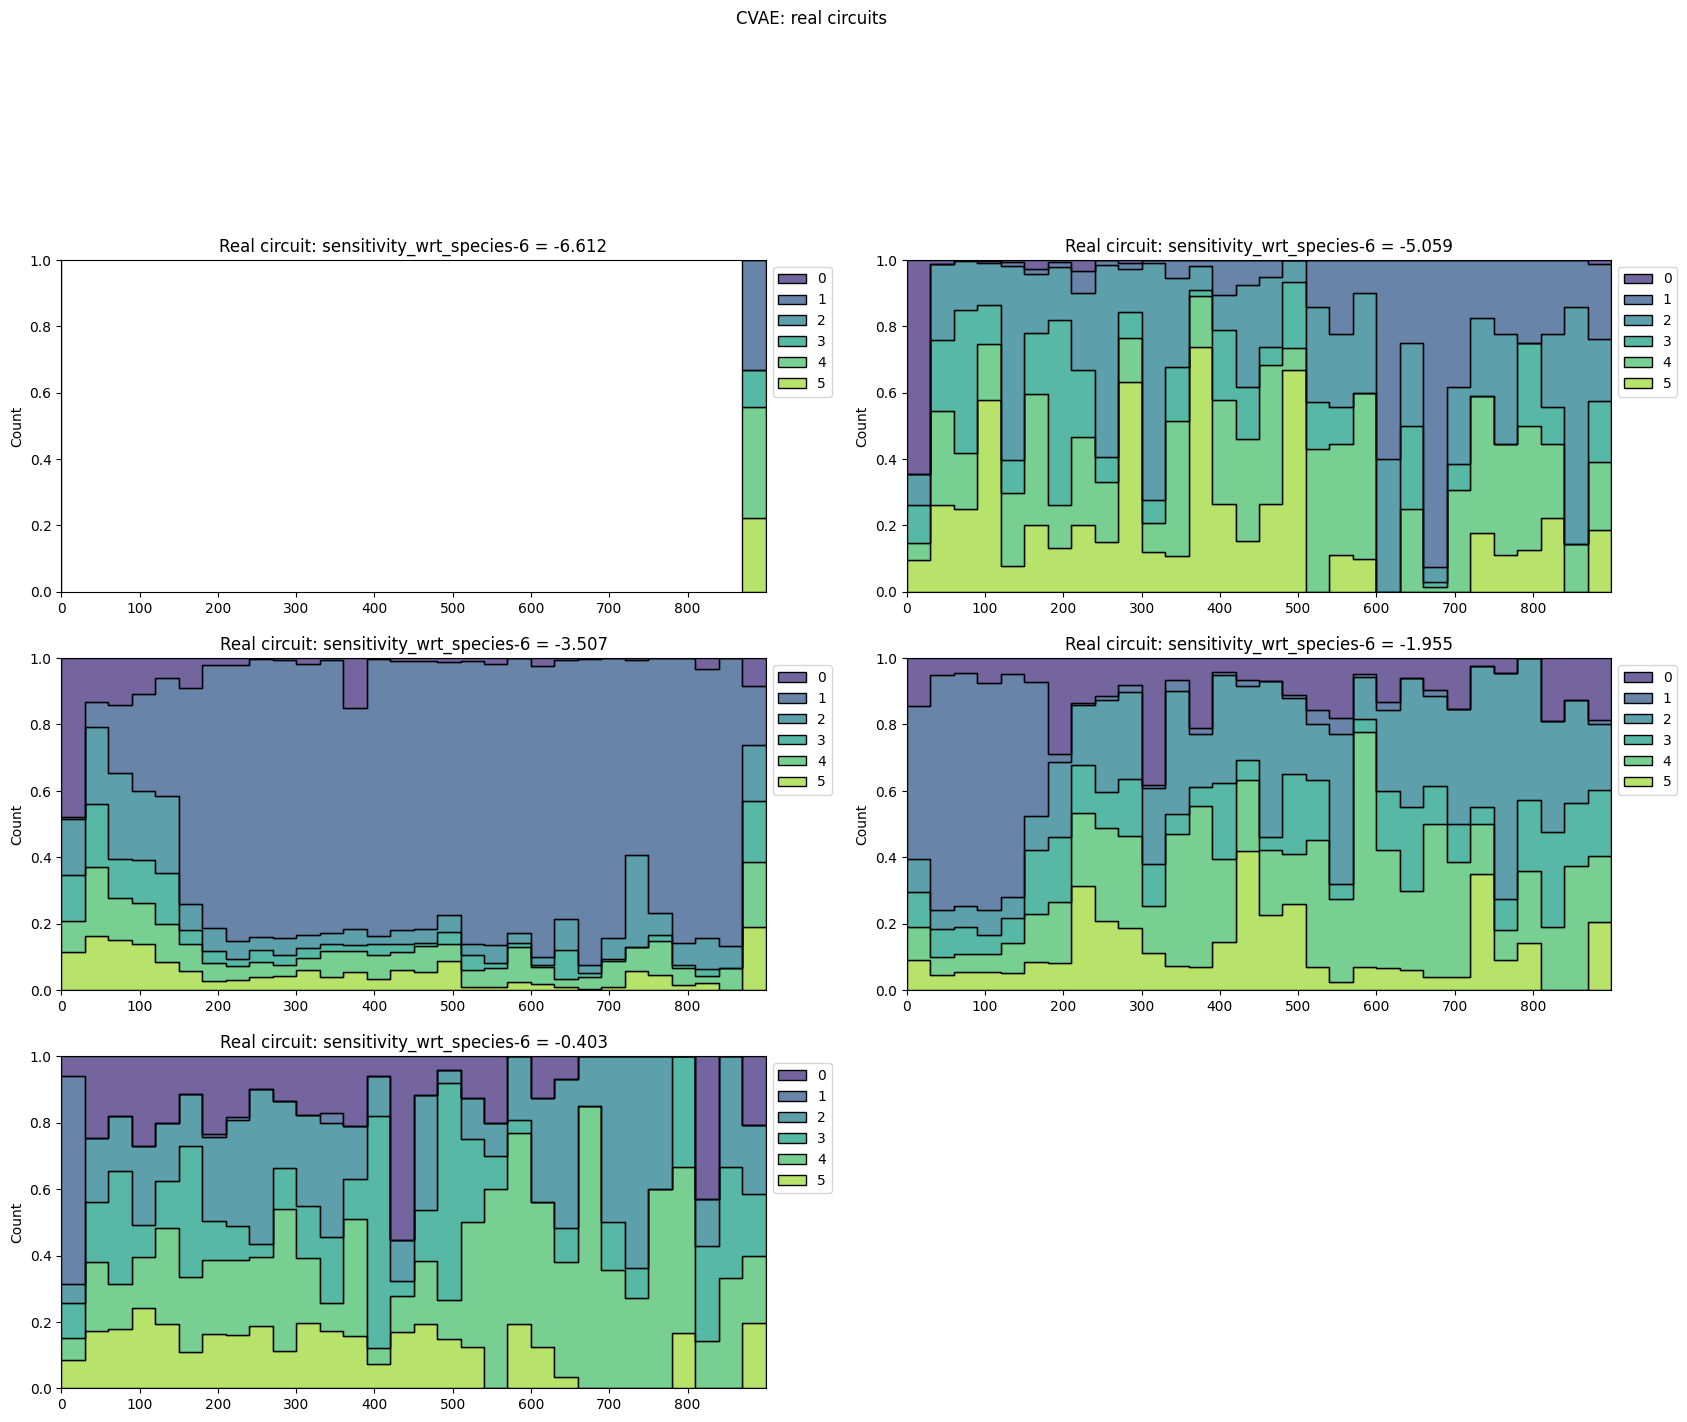

In [ ]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
widest_lim = [0, 0]
for i, edge in enumerate(sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique())):
    cat = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge]
    cat = cat[X_COLS[0]].to_numpy()
    
    ax = plt.subplot(5, 2, i+1)
    # g = sns.scatterplot(cat[:show_max])
    g = sns.histplot(cat, element='step', bins=30, palette='viridis', multiple='fill')
    plt.title(f'Real circuit: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g, 'upper left', bbox_to_anchor=(1, 1))
    widest_lim[0] = np.min([g.get_xlim()[0], widest_lim[0]])
    widest_lim[1] = np.max([g.get_xlim()[1], widest_lim[1]])
    g.set_xlim(widest_lim)

plt.suptitle(f'CVAE: real circuits')

### Combined

Text(0.5, 0.98, 'CVAE: circuit comparison fake vs. real')

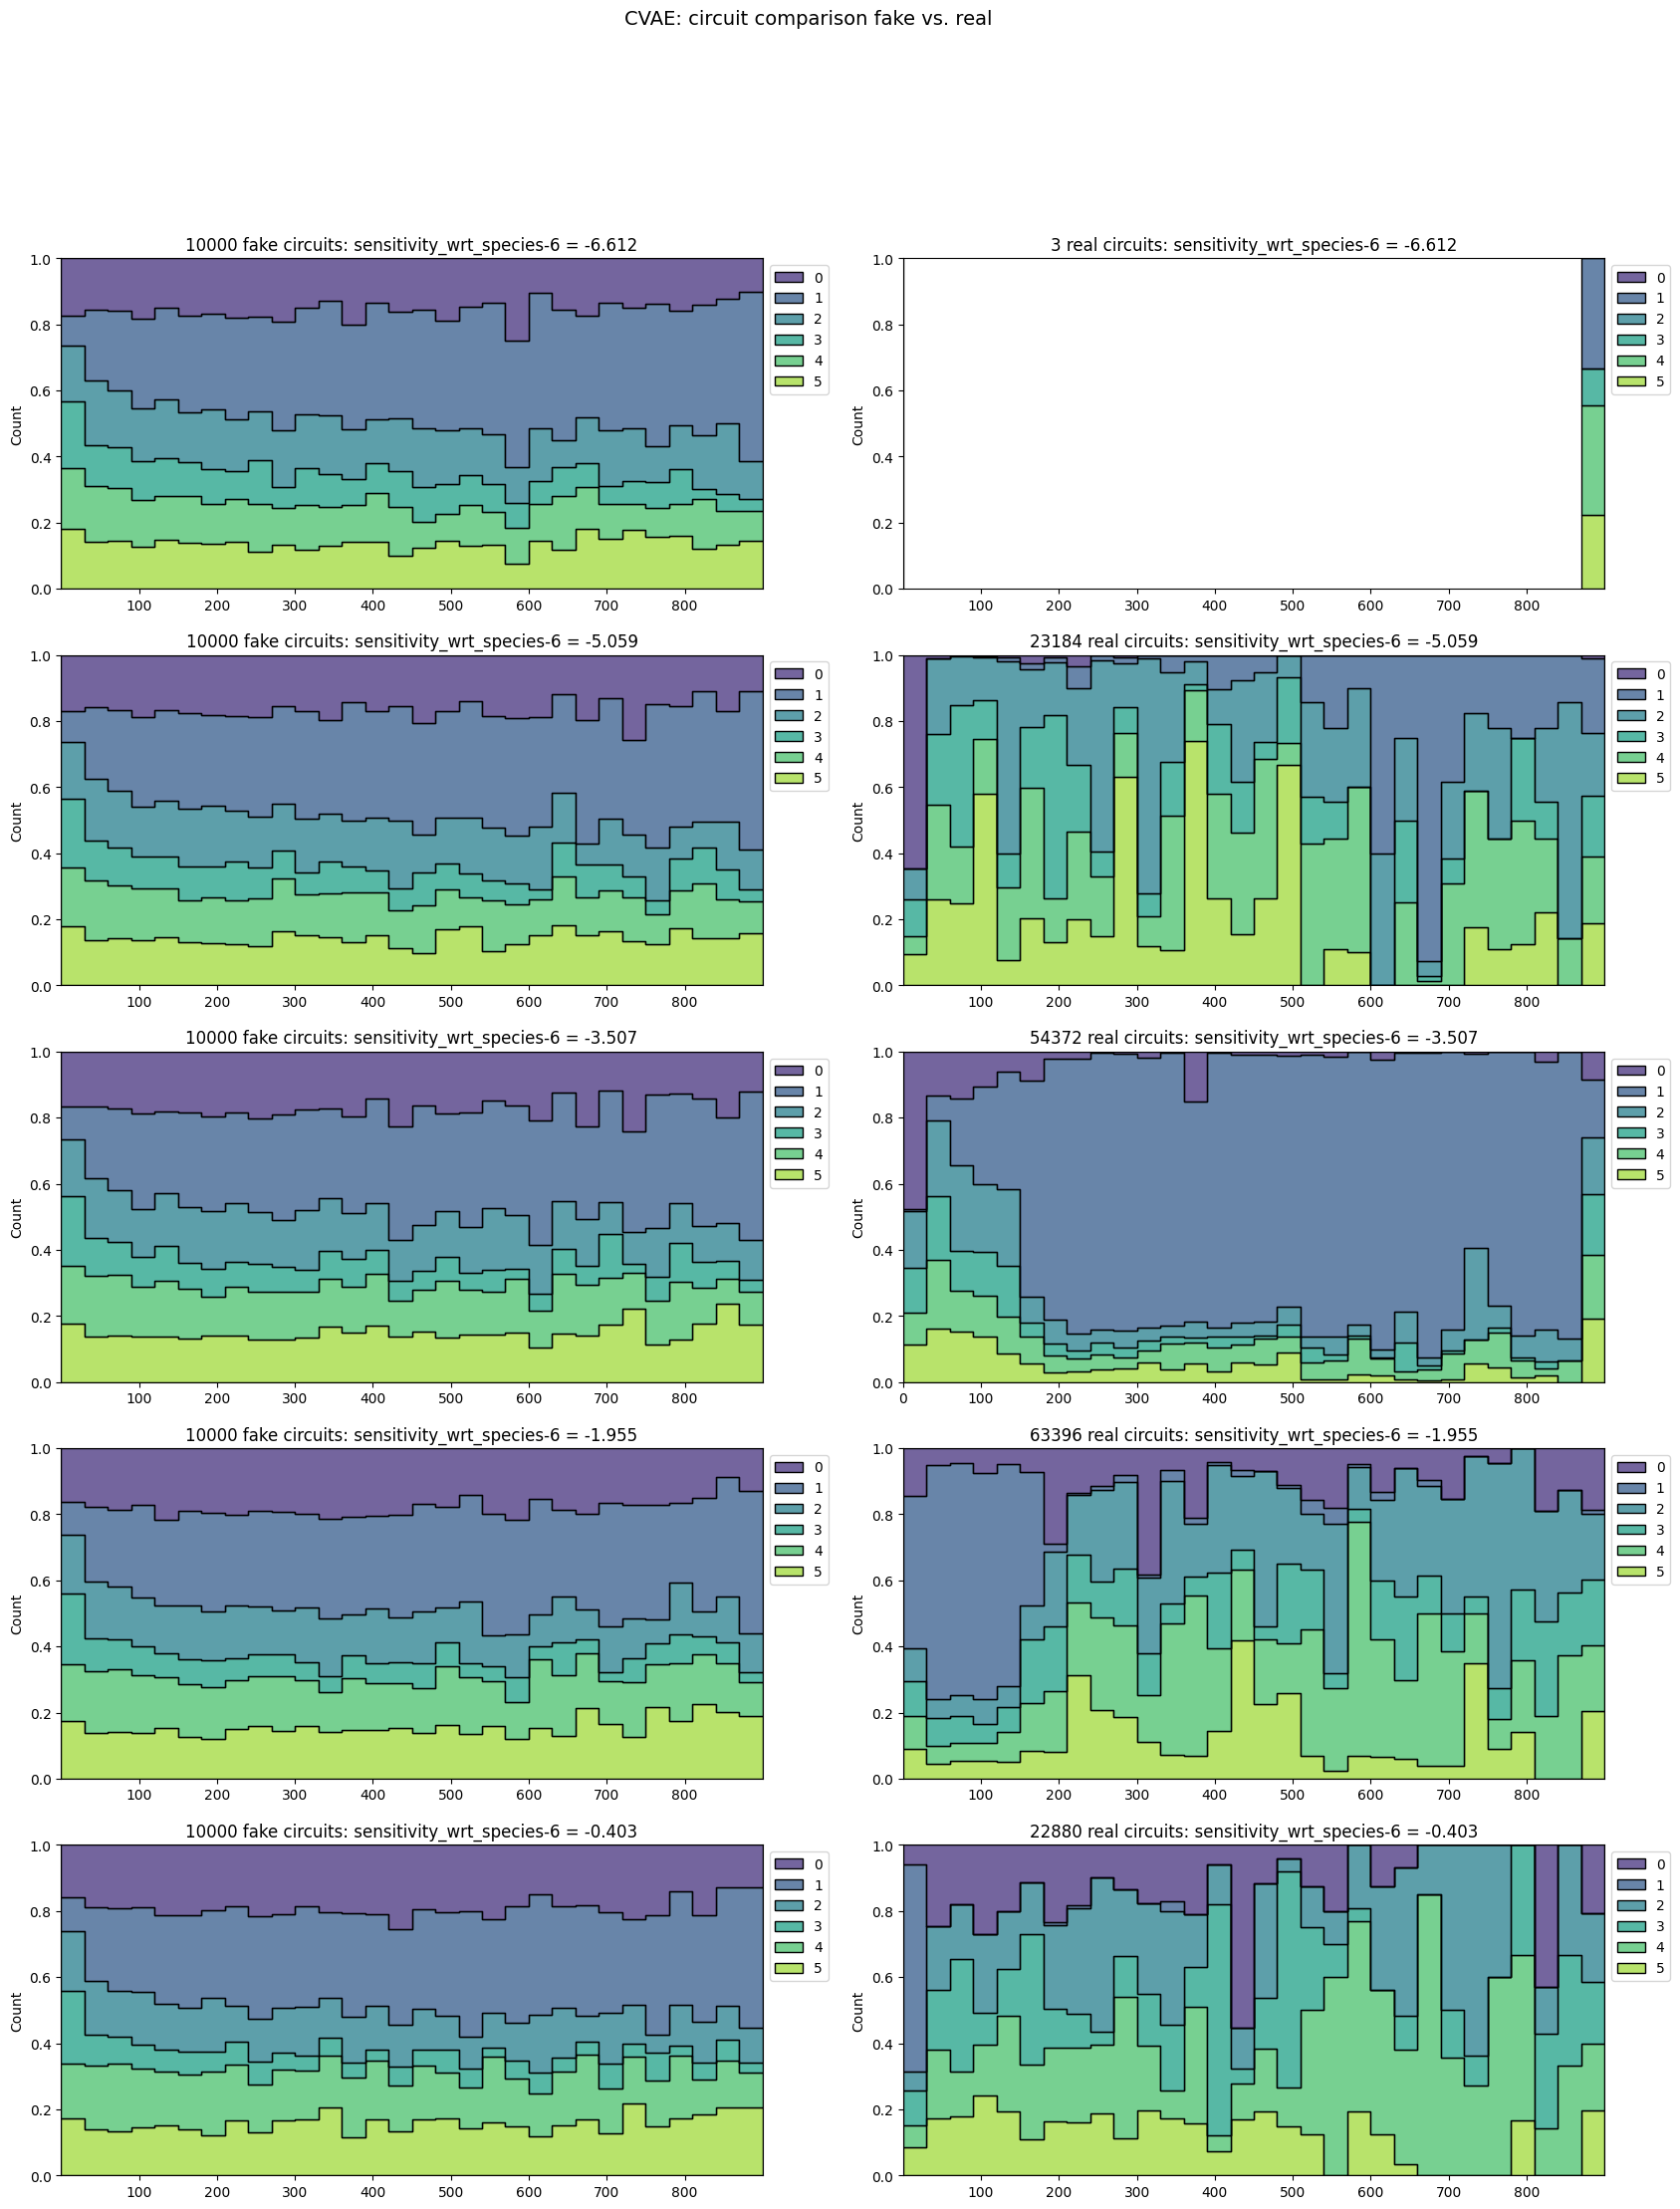

In [ ]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
for i, (zi, fake, edge) in enumerate(zip(z, fake_circuits, sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique()))):
    widest_lim = [0, 0]
    real = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge][X_COLS[0]].to_numpy()
    
    ax = plt.subplot(5, 2, 2*i+1)
    # g = sns.scatterplot(cat[:show_max])
    g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='fill')
    plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {str(sorted(np.unique(sampled_cond))[i])[:6]}')
    sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
    
    ax = plt.subplot(5, 2, 2*i+2)
    # g = sns.scatterplot(cat[:show_max])
    g2 = sns.histplot(real, element='step', bins=30, palette='viridis', multiple='fill')
    plt.title(f'{len(real)} real circuits: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
    
    widest_lim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0], widest_lim[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1], widest_lim[1]])]
    # g1.set_xlim(widest_lim)
    # g2.set_xlim(widest_lim)


plt.suptitle(f'CVAE: circuit comparison fake vs. real', fontsize=14)

Text(0.5, 0.98, 'CVAE: circuit comparison fake vs. real')

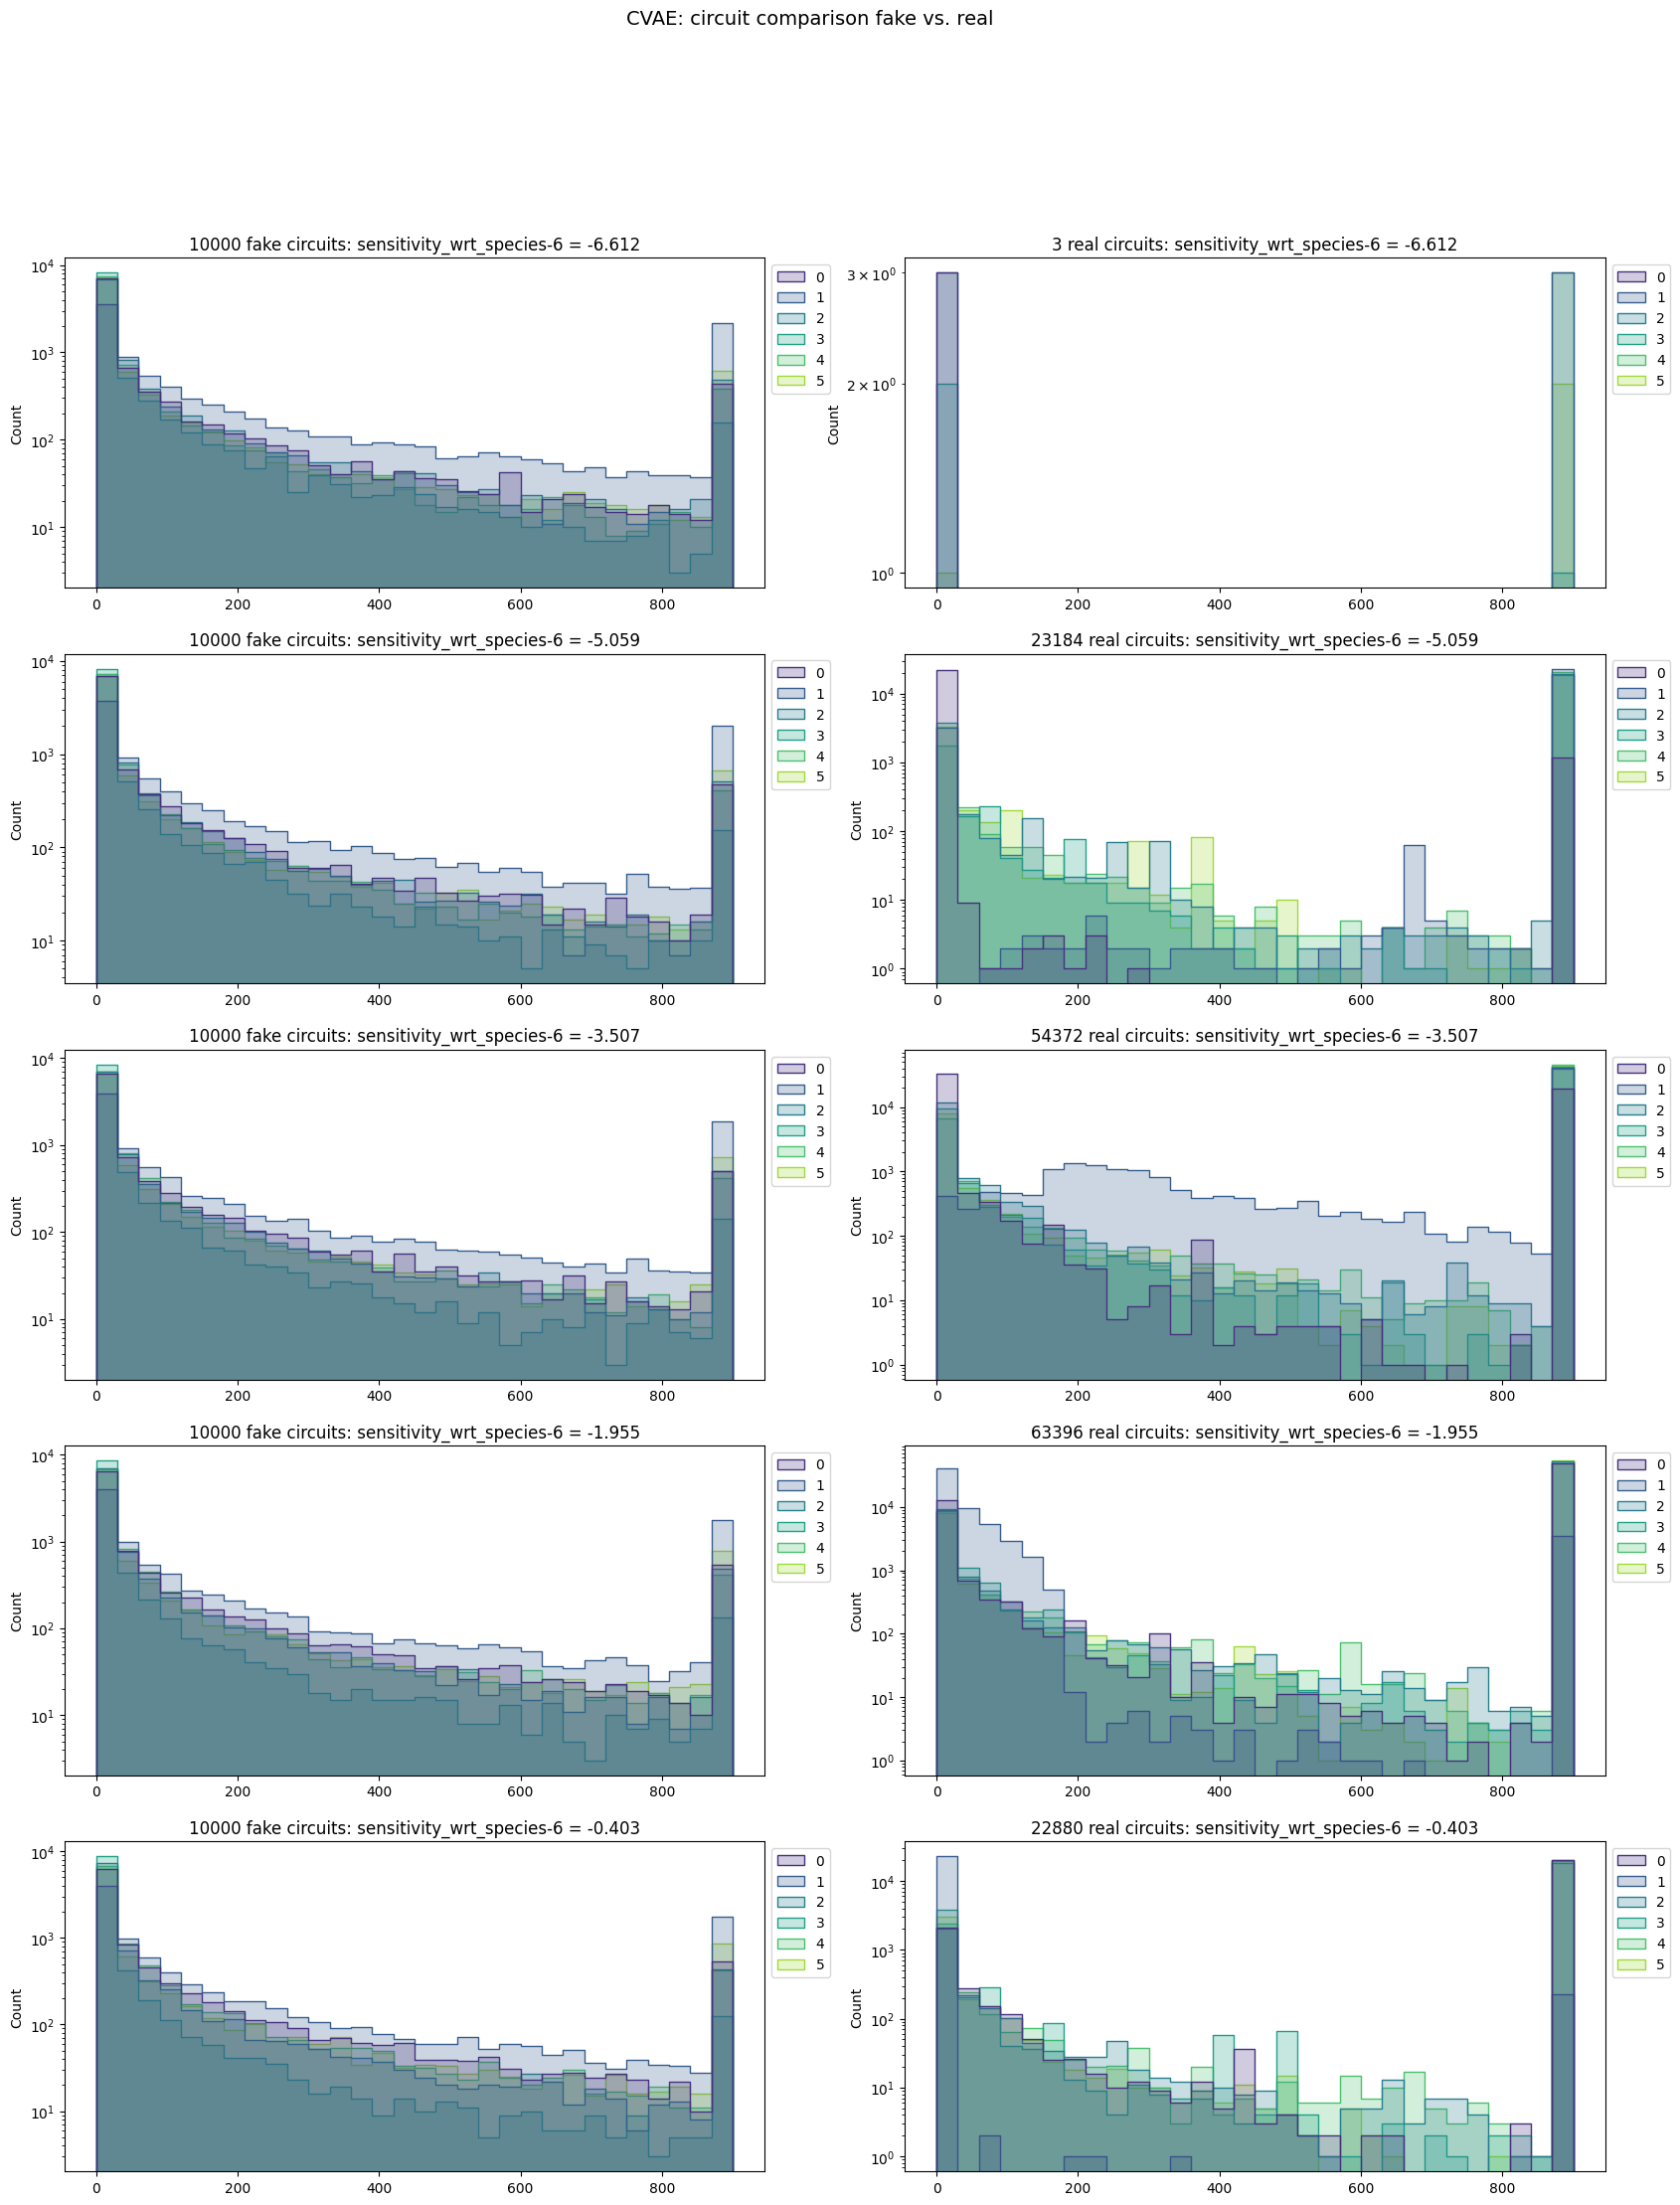

In [ ]:
fig = plt.figure(figsize=(10*2, 5*5))
show_max = 300 #n_to_sample
for i, (zi, fake, edge) in enumerate(zip(z, fake_circuits, sorted(df[OBJECTIVE_COL + '_nearest_edge'].unique()))):
    real = df[df[OBJECTIVE_COL + '_nearest_edge'] == edge][X_COLS[0]].to_numpy()
    
    ax = plt.subplot(5, 2, 2*i+1)
    # g = sns.scatterplot(cat[:show_max])
    g1 = sns.histplot(fake, element='step', bins=30, palette='viridis', multiple='layer', log_scale=[False, True])
    plt.title(f'{len(fake)} fake circuits: {OBJECTIVE_COL} = {str(sorted(np.unique(sampled_cond))[i])[:6]}')
    sns.move_legend(g1, 'upper left', bbox_to_anchor=(1, 1))
    
    ax = plt.subplot(5, 2, 2*i+2)
    # g = sns.scatterplot(cat[:show_max])
    g2 = sns.histplot(real, element='step', bins=30, palette='viridis', multiple='layer', log_scale=[False, True])
    plt.title(f'{len(real)} real circuits: {OBJECTIVE_COL} = {str(edge)[:6]}')
    sns.move_legend(g2, 'upper left', bbox_to_anchor=(1, 1))
    
    widest_xlim = [np.min([g1.get_xlim()[0], g2.get_xlim()[0]]), np.max([g1.get_xlim()[1], g2.get_xlim()[1]])]
    widest_ylim = [np.min([g1.get_ylim()[0], g2.get_ylim()[0]]), np.max([g1.get_ylim()[1], g2.get_ylim()[1]])]
    # g1.set_xlim(widest_xlim)
    # g2.set_ylim(widest_ylim)


plt.suptitle(f'CVAE: circuit comparison fake vs. real', fontsize=14)